<a href="https://colab.research.google.com/github/edwin-19/Sound-DL-Pytorch/blob/main/Sound_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install necessary libs

In [1]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip
!pip install pytorch-lightning

--2022-12-31 16:54:07--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2022-12-31 16:54:07--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2022-12-31 16:54:07--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.1’

master.zip.1            [ 

# Import Libraries

In [2]:
import soundfile as sf
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Load Data & EDA

In [3]:
wav_root = Path('ESC-50-master/audio/')
wavs = list(wav_root.glob('*.wav'))

In [4]:
target_class = [int(wav.stem.split('-')[-1]) for wav in wavs]
count_class = {}

for t_class in target_class:
  if t_class not in count_class:
    count_class[t_class] = 1
  else:
    count_class[t_class] += 1
  
count_class = {k: v for k, v in sorted(count_class.items(), key=lambda item: item[0])}

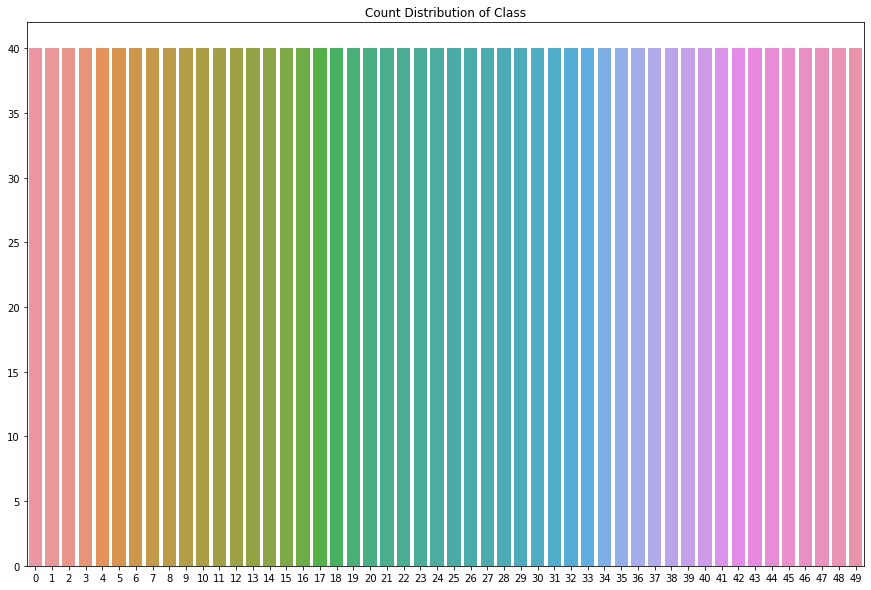

In [5]:
plt.figure(figsize=(15, 10))
plt.title('Count Distribution of Class')
sns.barplot(x=list(count_class.keys()), y=list(count_class.values()))

In [6]:
item = np.random.choice(wavs)
print('Display Audio: {}'.format(item))
Audio(item)

Display Audio: ESC-50-master/audio/5-243773-A-44.wav


# Build dataset
- resample to 16k
- convert to melspec

In [7]:
import librosa.display as display

In [8]:
aud, sr = torchaudio.load(np.random.choice(wavs))
aud = torchaudio.functional.resample(aud, sr, 16000)

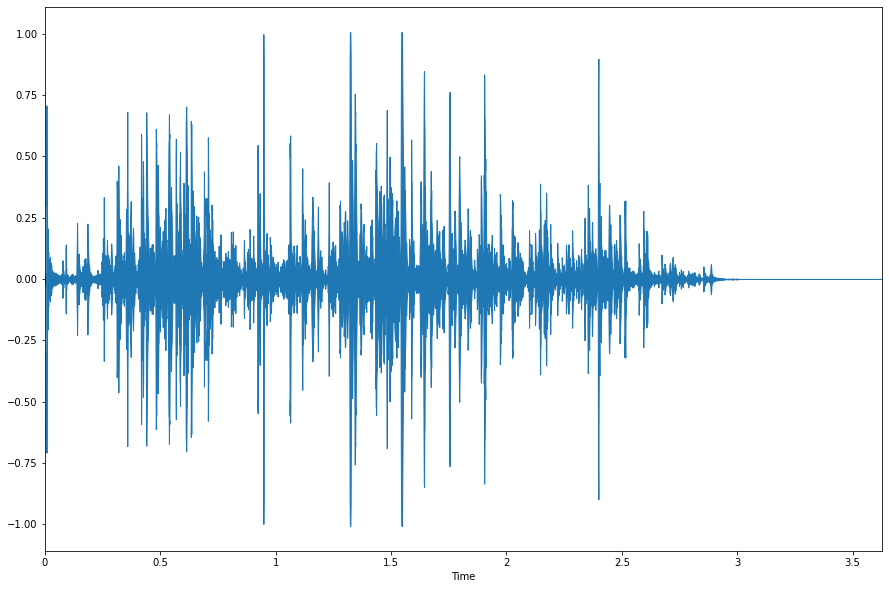

In [9]:
plt.figure(figsize=(15, 10))
display.waveplot(aud[0].numpy())

In [10]:
mel_transform = transforms.MelSpectrogram(
    sample_rate=16000, n_mels=80
)
melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()

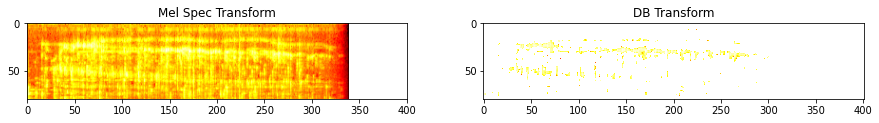

In [11]:
mel_spec = mel_transform(aud)
mel_db = melspectogram_db_transform(mel_spec)

plt.figure(figsize=(15, 10))

plt.subplot(1 , 2, 1)
plt.title('Mel Spec Transform')
plt.imshow(mel_spec.log2()[0,:,:].numpy(), cmap='hot')

plt.subplot(1 , 2, 2)
plt.title('DB Transform')
plt.imshow(mel_db.log2()[0,:,:].numpy(), cmap='hot')

In [12]:
class AudioDataset(Dataset):
  def __init__(self, wavs_paths, sample_rate=16000, n_mels=80):
    self.wavs_paths = wavs_paths
    self.sample_rate = sample_rate
    self.n_mels = n_mels
    self.mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=n_mels
    )
    self.melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()

  def __len__(self):
    return len(self.wavs_paths)

  def __getitem__(self, index):
    wav_file = self.wavs_paths[index]
    target_class = int(wav_file.stem.split('-')[-1])

    # Load audio
    waveform, sr = torchaudio.load(wav_file)

    # Resample to 16k
    waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

    # convert to mono
    waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Convert to melspec
    mel_spec = self.mel_transform(waveform)
    mel_spec = self.melspectogram_db_transform(mel_spec)

    #Make sure all spectrograms are the same size
    fixed_length = 3 * (self.sample_rate // 200)
    if mel_spec.shape[2] < fixed_length:
        mel_spec = torch.nn.functional.pad(mel_spec, (0, fixed_length - mel_spec.shape[2]))
    else:
        mel_spec = mel_spec[:, :, :fixed_length]

    return mel_spec, torch.tensor(target_class)

In [13]:
from sklearn.model_selection import train_test_split
class AudioDataModule(pl.LightningDataModule):
  def __init__(self, wavs_paths, batch_size=64):
    super(AudioDataModule, self).__init__()

    self.wavs_paths = wavs_paths
    self.batch_size = batch_size
  
  def setup(self, stage=None):
    train_wavs, val_wavs = train_test_split(self.wavs_paths, test_size=0.2, random_state=2023)

    self.train_dataset = AudioDataset(train_wavs)
    self.val_dataset = AudioDataset(val_wavs)

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, shuffle=True,
        batch_size=self.batch_size, num_workers=2, 
        pin_memory=True
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.val_dataset, shuffle=False,
        batch_size=self.batch_size, num_workers=2, 
        pin_memory=True
    )

In [14]:
datamodule = AudioDataModule(wavs)
datamodule.setup()

# Build model
- Using resnet18 we will create a classifier

In [15]:
from torchvision.models import resnet18
from torchmetrics import Accuracy

In [24]:
class AudioClassifier(pl.LightningModule):
  def __init__(self, num_class=50):
    super(AudioClassifier, self).__init__()

    self.model = resnet18(pretrained=True)
    self.model.conv1=nn.Conv2d(1, self.model.conv1.out_channels, 
                      kernel_size=self.model.conv1.kernel_size[0], 
                      stride=self.model.conv1.stride[0], 
                      padding=self.model.conv1.padding[0])
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, num_class)

    self.criterion = nn.CrossEntropyLoss()
    self.train_acc = Accuracy(task='multiclass', num_classes=num_class)
    self.val_acc = Accuracy(task='multiclass', num_classes=num_class)

  def forward(self, mel_spec):
    return self.model(mel_spec)

  def training_step(self, batch, batch_idx):
    mel_spec, target_class = batch

    logits = self(mel_spec)
    loss = self.criterion(logits, target_class)
    self.train_acc(logits.argmax(dim=1), target_class)

    self.log_dict({
        'train_loss': loss,
        'train_acc': self.train_acc
    }, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    mel_spec, target_class = batch

    logits = self(mel_spec)
    loss = self.criterion(logits, target_class)
    self.val_acc(logits.argmax(dim=1), target_class)

    self.log_dict({
        'val_loss': loss,
        'val_acc': self.val_acc
    }, prog_bar=True)

    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return [optimizer]

In [25]:
model = AudioClassifier(num_class=len(count_class))

# Create trainer & train

In [26]:
model_ckpt = pl.callbacks.ModelCheckpoint(
  monitor='val_loss',
  mode='min',
  save_top_k=3,
  filename='ckpt/audio-classifier{epoch:02d}-val_loss{val_loss:.2f}',    
)

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min', patience=3
)

trainer = pl.Trainer(
    max_epochs=20, callbacks=[model_ckpt, early_stopping],
    devices=[0], gradient_clip_val=0.5, accelerator='gpu',
    log_every_n_steps=20
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.784    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Model Inference

In [55]:
sel_wav = np.random.choice(wavs)
target_class = int(sel_wav.stem.split('-')[-1])
waveform , sr = torchaudio.load(sel_wav)
waveform = torchaudio.functional.resample(waveform, sr, 16000)

mel_spec = mel_transform(waveform)
mel_spec = melspectogram_db_transform(mel_spec)

logits = model(mel_spec.unsqueeze(0))

In [56]:
pred = logits.softmax(dim=1)
pred_score = pred.detach().numpy().max()
pred_class = pred.detach().numpy().argmax()

In [57]:
print('Pred Class: {}, Pred Score: {}\nGT: {}'.format(pred_class, pred_score, target_class))

Pred Class: 7, Pred Score: 0.038209427148103714
GT: 5
